<a href="https://colab.research.google.com/github/dragonsan17/denoising_deep_image_prior/blob/master/denoising_single_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is an inference notebook, showing denoising of images using an 'hourglass' architecture (or an encoder-decoder model) as shown in **Deep Image Prior Paper**. This approach is to show that the randomly initialized neural network can be used as an image prior with excellent results in standard image inversion problems such as denoising, **without any training**.

Here, inference is shown on some sample images taken from CIFAR-10 dataset, present in the data directory. You can run inference on the F16-GT airplane image, which was originally used in the paper to show the denoising results.

*Paper* *: https://sites.skoltech.ru/app/data/uploads/sites/25/2018/04/deep_image_prior.pdf*

In [1]:
!git clone https://github.com/dragonsan17/denoising_deep_image_prior
!mv denoising_deep_image_prior/* ./

Cloning into 'denoising_deep_image_prior'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import os
import numpy as np
import torch
import torch.optim
from skimage.measure import compare_psnr
from tqdm.notebook import tqdm
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
from utils import *
from hourglass_architecture import *
import warnings
warnings.filterwarnings("ignore")

# Config for CIFAR 10 Images

In [60]:
dtype = torch.cuda.FloatTensor
imsize =-1
PLOT = True
# fname = '/content/data/2.png'
# fname = '/content/data/5.png'
fname = '/content/data/9.png'
# fname = '/content/data/13.png'
# fname = '/content/data/21.png'


"""
  Currently implemented Gaussian, Salt and Pepper, Poisson and Speckle Noise
  params : gauss, s&p, poisson, speckle
"""
# type_of_noise = 'gauss'
# LR = 0.001
# num_iter = 500


# type_of_noise = 's&p'
# LR = 0.0001
# num_iter = 1100


# type_of_noise = 'poisson'
# LR = 0.001
# num_iter = 350
# val = 1.8

type_of_noise = 'speckle'
LR = 0.001
num_iter = 500

input_depth = 32 
figsize = 4 
skip_n33d=32 
skip_n33u=32
skip_n11=4 
num_scales=3
sigma = 15/255
show_every = 50
exp_weight=0.99
reg_noise_std = 1./30.
pad = 'reflection'
OPT_OVER = 'net'
factor = 15
amount = 0.02

# Config for FG-16 Image - Used in paper

In [61]:
# dtype = torch.cuda.FloatTensor
# imsize =-1
# PLOT = True
# fname = '/content/data/F16_GT.png'

# """
#   Currently implemented Gaussian, Salt and Pepper, Poisson and Speckle Noise
#   params : gauss, s&p, poisson, speckle
# """
# type_of_noise = 'gauss'
# pad = 'reflection'
# OPT_OVER = 'net'
# reg_noise_std = 1./30.
# LR = 0.01
# show_every = 50
# exp_weight=0.99
# num_iter = 2400
# input_depth = 32 
# figsize = 4 
# skip_n33d=128 
# skip_n33u=128
# skip_n11=4 
# num_scales=5
# sigma = 50/255
# factor = 30

# Adding Noise

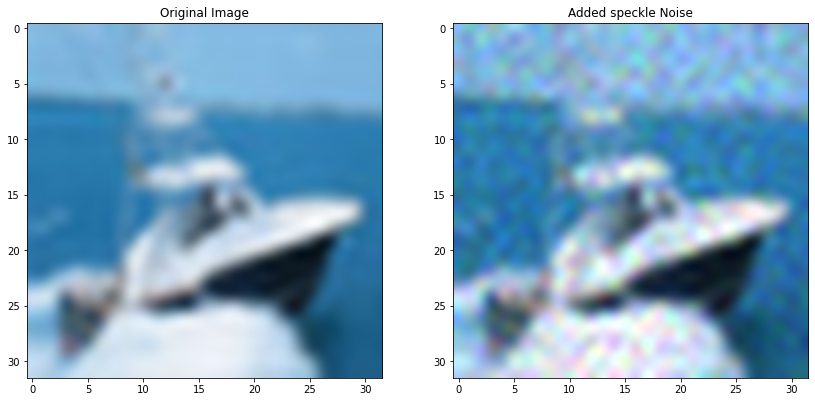

In [62]:
# Add synthetic noise
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img = pil_to_np(img_pil)
img_noise = noisy(type_of_noise,img, sigma = sigma, amount = amount, val = val)
plot_image_grid([img, img_noise], 8, 12, labels = ['Original Image','Added ' + type_of_noise + ' Noise'])

# Code

In [63]:
net = get_net(input_depth, pad,
              skip_n33d=skip_n33d, 
              skip_n33u=skip_n33u, 
              skip_n11=skip_n11, 
              num_scales=num_scales,
              upsample_mode='bilinear').type(dtype)

net_input = get_noise(input_depth, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
print(net_input.shape)
mse = torch.nn.MSELoss().type(dtype)
img_noisy_torch = np_to_torch(img_noise).type(dtype)

out_avg = None
last_net = None
psrn_noisy_last = 0
net_input_saved = net_input.detach().clone()
print(net_input_saved.shape)
noise = net_input.detach().clone()

torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])


In [64]:
def engine(parameters, net, num_iter, LR, img_np, img_noisy_np):
  global out_avg, psrn_noisy_last, last_net, net_input
  optimizer = torch.optim.Adam(parameters, lr=LR)
  
  bar = tqdm(np.arange(num_iter), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
  for j in bar:
      optimizer.zero_grad()
      if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
      out = net(net_input)
      # Smoothing
      if out_avg is None:
          out_avg = out.detach()
      else:
          out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
              
      total_loss = mse(out, img_noisy_torch)
      total_loss.backward()
      psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
      psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
      psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 

      content = f'Iteration: {j} , Loss: {total_loss.item():.3f} , PSNR_noisy: {psrn_noisy:.3f} , PSRN_gt:{psrn_gt:.3f}            '
      bar.set_description(content)
      if  PLOT and j % show_every == 0:
          out_np = torch_to_np(out)
          print('Iteration : ', j)
          plot_image_grid([np.clip(out_np, 0, 1), 
                            np.clip(torch_to_np(out_avg), 0, 1)],factor=12, nrow=8, labels = ['Output', 'Average Output'])
          
      # Backtracking
      if j % show_every:
          if psrn_noisy - psrn_noisy_last < -5: 
              print('Falling back to previous checkpoint.')

              for new_param, net_param in zip(last_net, net.parameters()):
                  net_param.data.copy_(new_param.cuda())

              return total_loss*0
          else:
              last_net = [x.detach().cpu() for x in net.parameters()]
              psrn_noisy_last = psrn_noisy
              
      optimizer.step()

Iteration :  0


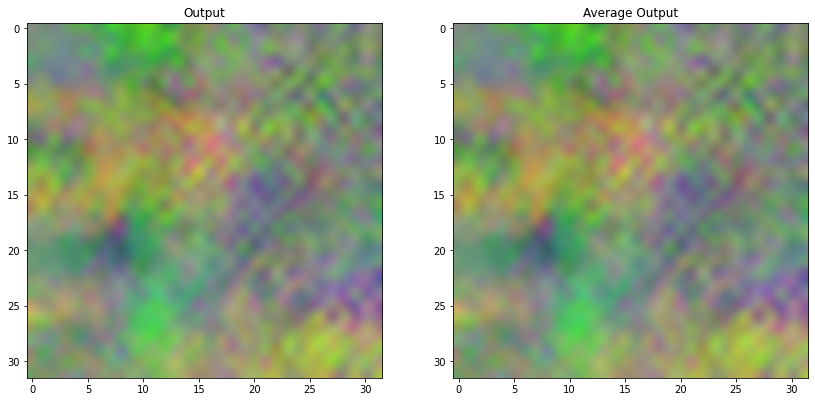

Iteration :  50


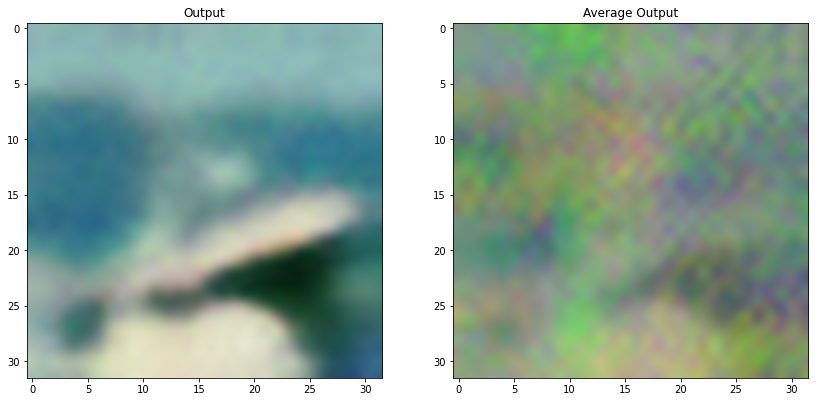

Iteration :  100


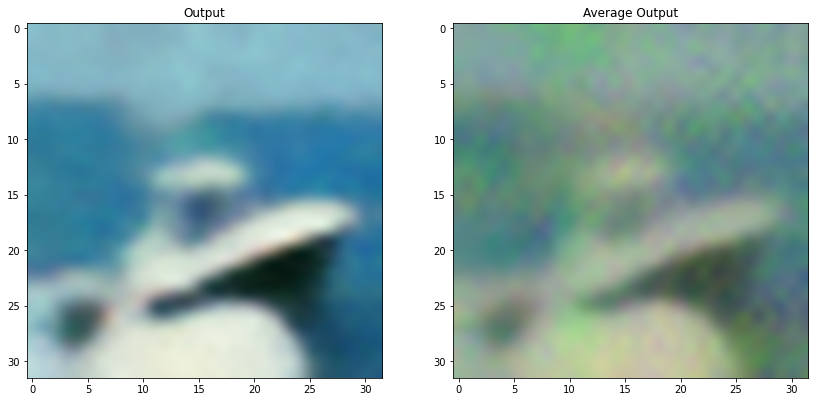

Iteration :  150


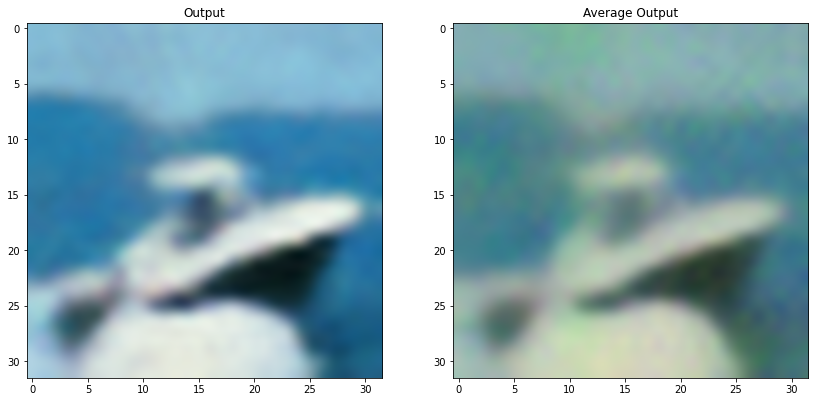

Iteration :  200


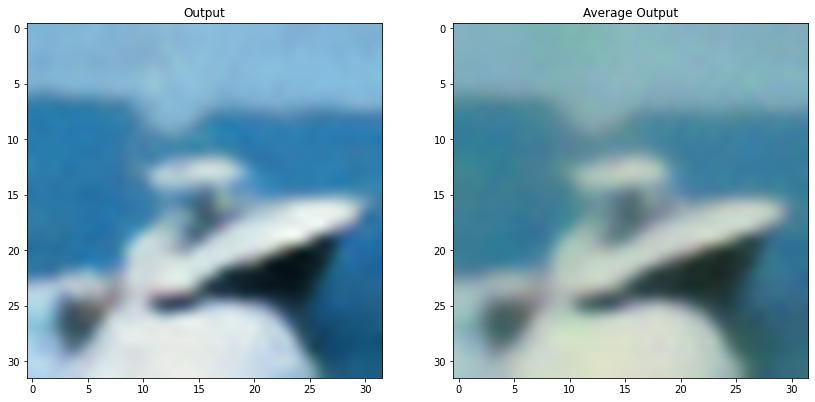

Iteration :  250


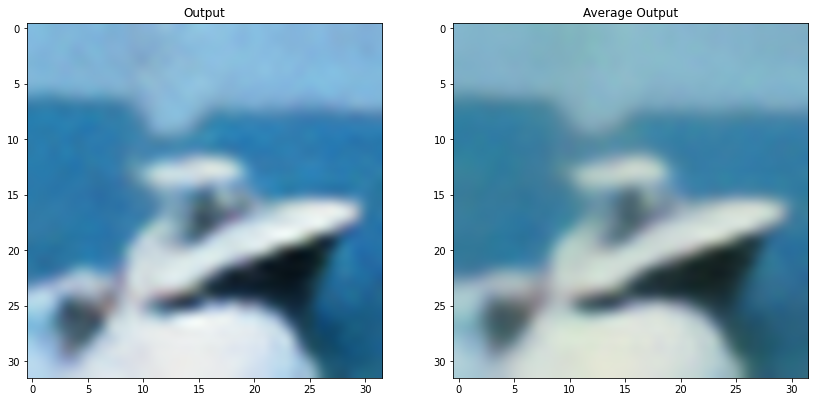

Iteration :  300


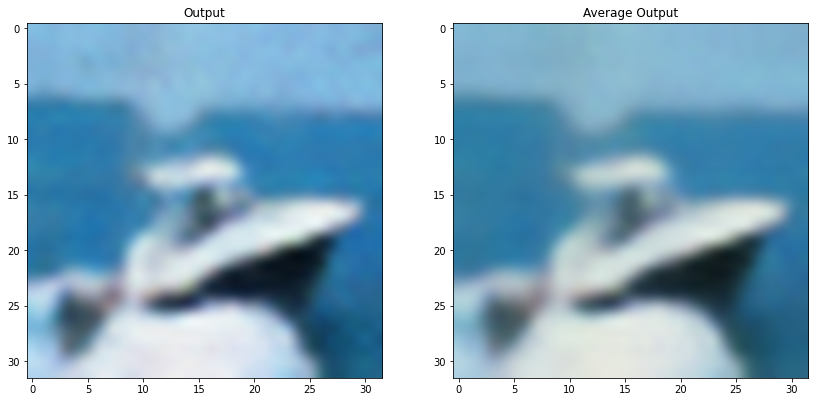

Iteration :  350


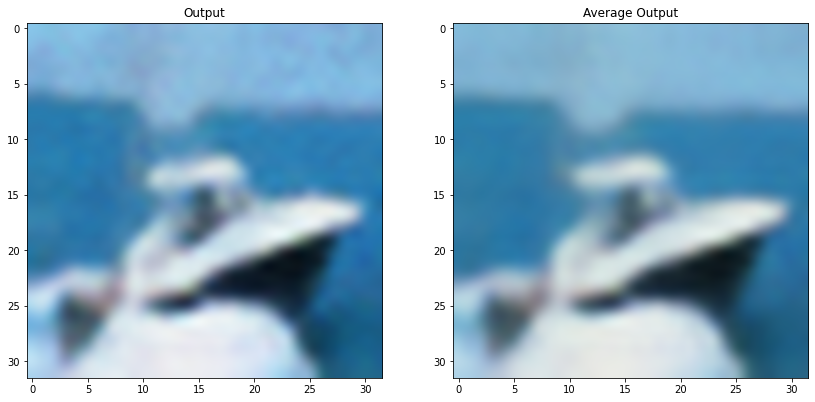

Iteration :  400


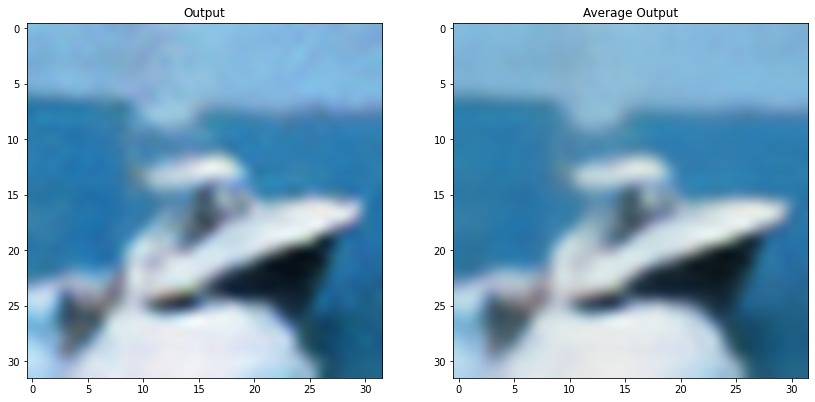

Iteration :  450


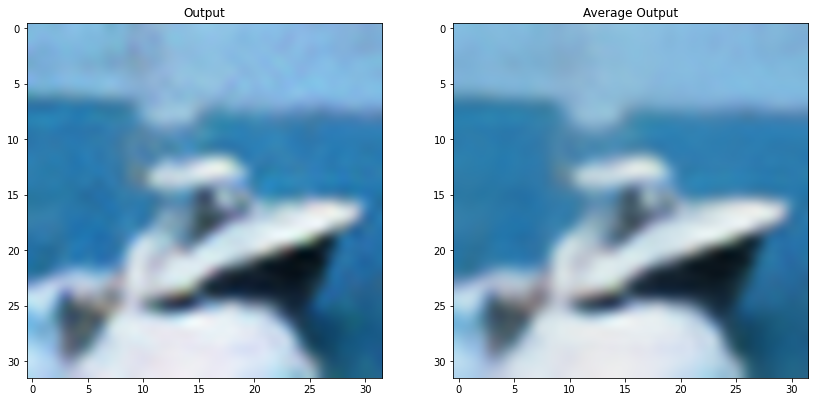

In [65]:
parameters = get_params(OPT_OVER, net, net_input)
engine(parameters, net, num_iter, LR, img, img_noise)

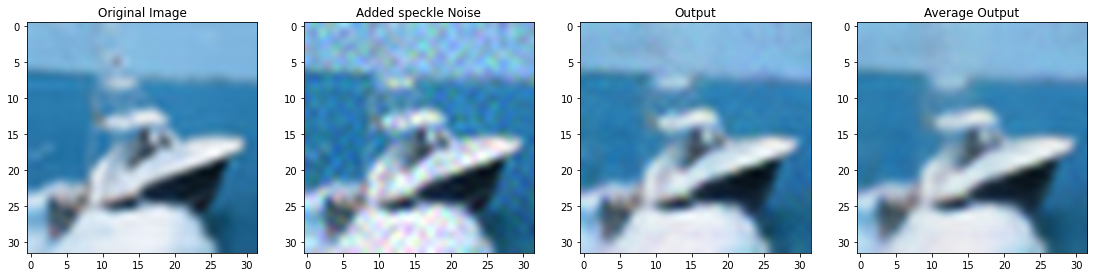

In [66]:
out_np = torch_to_np(net(net_input))
plot_image_grid([img, img_noise, np.clip(out_np, 0, 1), np.clip(torch_to_np(out_avg), 0, 1)], factor = factor, labels = ['Original Image', 'Added ' + type_of_noise + ' Noise', 'Output', 'Average Output']);